## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08250.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03270.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01290.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02250_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02220_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07965_P.png')]

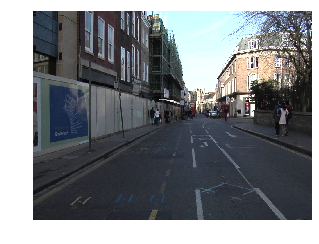

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

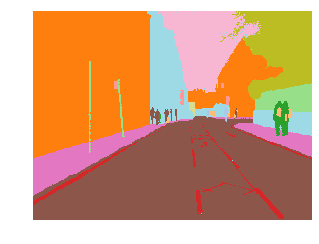

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 8109MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

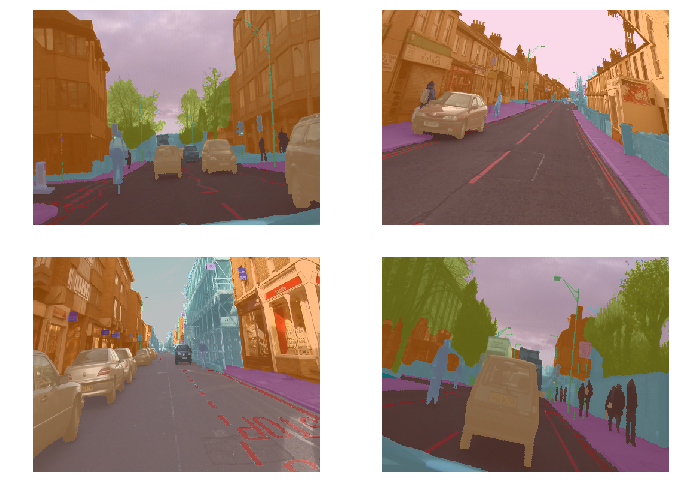

In [16]:
data.show_batch(2, figsize=(10,7))

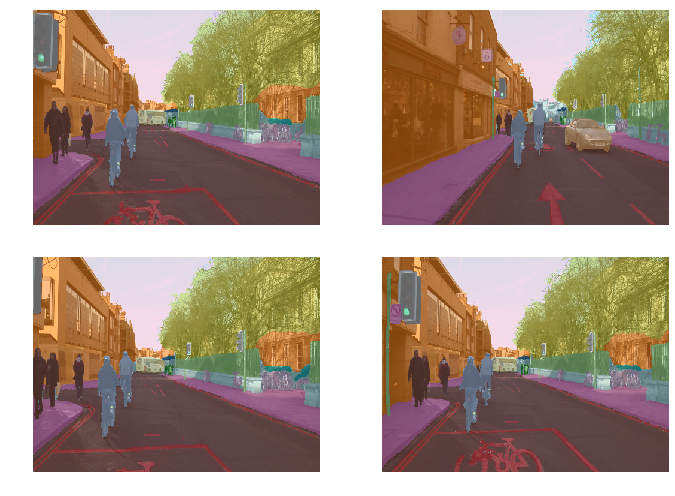

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [22]:
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


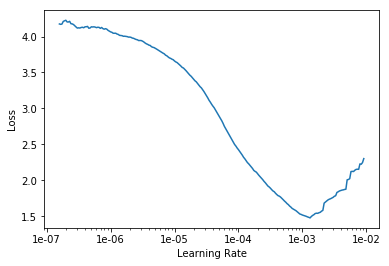

In [22]:
lr_find(learn, num_it=400)
learn.recorder.plot()

In [23]:
lr=1e-4

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.327383,1.709315,0.622795,01:08
1,1.178501,1.004042,0.798031,01:07
2,0.865443,0.753324,0.821892,01:07
3,0.723439,0.598457,0.838924,01:07
4,0.659378,0.561212,0.838767,01:07
5,0.639472,0.478549,0.862038,01:07
6,0.547588,0.426443,0.880127,01:07
7,0.527129,0.399941,0.886740,01:07
8,0.480944,0.408922,0.879746,01:07
9,0.414860,0.341192,0.899295,01:07


In [25]:
learn.save('stage-1')

In [26]:
# learn.load('stage-1');

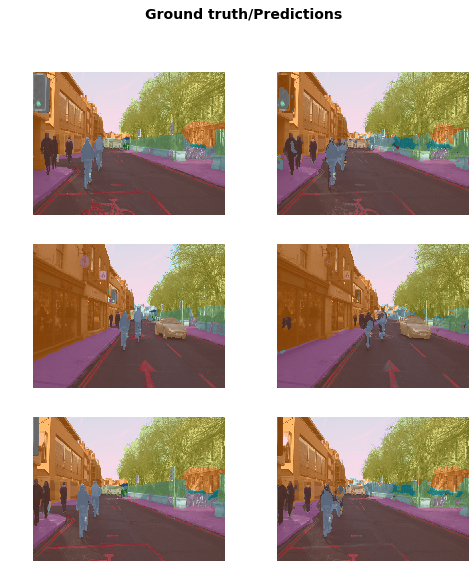

In [27]:
learn.show_results(rows=3, figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.377305,0.338578,0.900323,01:10
1,0.387366,0.338944,0.899639,01:11
2,0.391111,0.336655,0.900688,01:11
3,0.378600,0.329714,0.903907,01:11
4,0.371100,0.334961,0.899907,01:11
5,0.365736,0.331832,0.902753,01:11
6,0.362608,0.324399,0.903973,01:11
7,0.348054,0.320615,0.906099,01:11
8,0.344694,0.313051,0.908035,01:11
9,0.348694,0.309291,0.910512,01:11


In [31]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [13]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 8109MB of GPU RAM free


In [16]:
data = (src
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [24]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


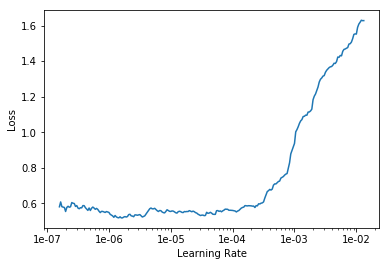

In [25]:
lr_find(learn, num_it=400)
learn.recorder.plot()

In [26]:
lr=2e-5

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.527102,0.341576,0.901830,04:34
1,0.499188,0.335971,0.902274,04:36
2,0.434251,0.348706,0.896246,04:37
3,0.402545,0.320269,0.905132,04:37
4,0.415557,0.325647,0.904526,04:37
5,0.395365,0.334393,0.899208,04:36
6,0.398445,0.318343,0.908051,04:36
7,0.376953,0.321170,0.905049,04:36
8,0.344563,0.290756,0.913530,04:37
9,0.324908,0.294544,0.912853,04:37


In [28]:
learn.save('stage-1-big')

In [29]:
learn.load('stage-1-big');

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.308841,0.293172,0.912514,05:13
1,0.312604,0.293536,0.912681,05:17
2,0.315259,0.284261,0.916446,05:17
3,0.291467,0.295887,0.913003,05:17


In [36]:
learn.save('stage-2-big')

In [ ]:
# learn.load('stage-2-big');

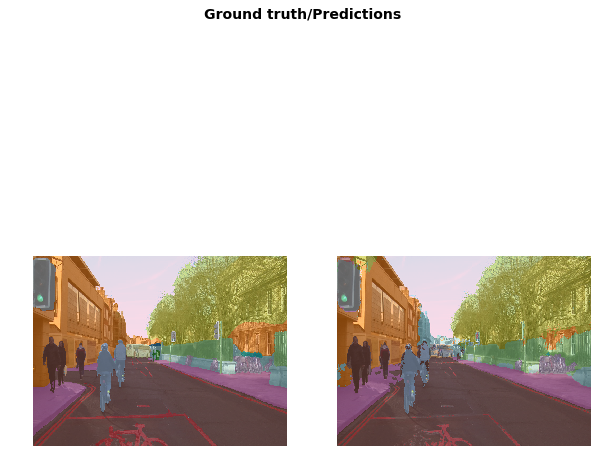

In [38]:
learn.show_results(rows=3, figsize=(10,10))

## fin